In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import datetime
import numpy as np

## Settings

In [2]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

input_path = './inputs/'
filename_exp = 'data_exp_03.csv'
filename_gaze = 'data_gaze_03.csv'
filename_video = '20230913_02.mp4'

output_path = './outputs/'
filename_position = f'position_{timestamp}.csv'
output_frame_dir = './outputs/frames/'

## Processing data

In [3]:
data_exp = pd.read_csv(input_path + filename_exp)
data_gaze = pd.read_csv(input_path + filename_gaze)

exp_timestamp = data_exp['etRecord_3.started']
exp_timestamp_clean = exp_timestamp.dropna()

first_value = exp_timestamp_clean.iloc[0]  # Get the first value
adjusted_value = [value - first_value for value in exp_timestamp_clean]
new_data = pd.DataFrame({'exp_index': adjusted_value})

gaze_timestamp = data_gaze['gaze_timestamp']
first_value = gaze_timestamp.iloc[0]
adjusted_value = [value - first_value for value in gaze_timestamp]
new_data2 = pd.DataFrame({'gaze_stamp': adjusted_value})

new_data2['norm_x'] = data_gaze['norm_pos_x']
new_data2['norm_y'] = data_gaze['norm_pos_y']

# Define the time interval for merging (e.g., +/- 1 second)
time_interval = 5.999

# Merge based on time intervals
merged_df = pd.merge_asof(
    new_data2,
    new_data,
    left_on='gaze_stamp',
    right_on='exp_index',
    direction='backward',  # Use 'backward' if you want to find the nearest exp_index value before gaze_stamp
    tolerance=time_interval
)

merged_df.to_csv(output_path+filename_position)


## Convert video to frames

In [4]:
# Create the output directory if it doesn't exist
output_frame_dir = output_frame_dir + '/' + timestamp

os.makedirs(output_frame_dir, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(input_path + filename_video)

# Get the frames per second (FPS) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f'video fps: {fps}')

frame_count = 0  # Initialize frame count

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Output every second frame (skip two out of every three frames)
    if frame_count % 3 == 0:
        # Save the frame as an image
        frame_filename = os.path.join(output_frame_dir, f'frame_{frame_count // 3:04d}.jpg')
        cv2.imwrite(frame_filename, frame)

    frame_count += 1

# Release the video capture
cap.release()


video fps: 29


## Visualization on Gaze data

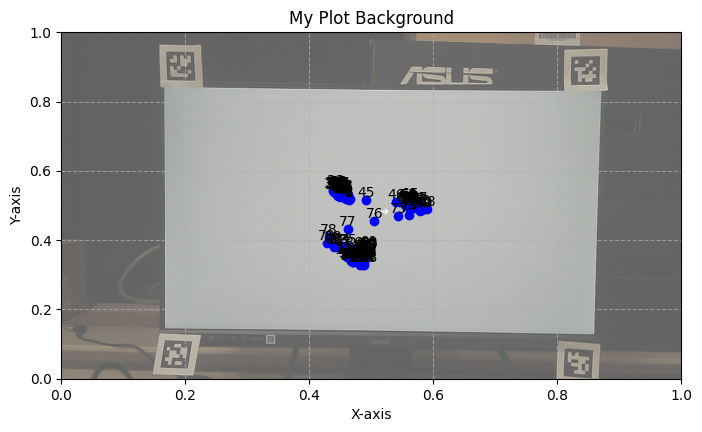

In [5]:
# Load your gaze data and timestamps from your DataFrame
merged_df = merged_df.copy()

# Define the list of seconds you want to display
display_second = 2  # Adjust this list as needed

range_init = display_second * 120
range_over = range_init + 120

# Extract relevant columns
timestamps = merged_df['gaze_stamp']

x_data = merged_df['norm_x'][range_init:range_over+1]
y_data = merged_df['norm_y'][range_init:range_over+1]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4.5))

# Set the background color
ax.set_facecolor('#f0f0f0')

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Set plot title
ax.set_title('My Plot Background')

# Set fixed X-axis and Y-axis limits (adjust as needed)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Scatter plot your gaze data
ax.scatter(x_data, y_data, label='Eye Tracking Data', color='blue', marker='o')

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax.text(x, y, str(i+1), ha='center', va='bottom', fontsize=10, color='black')

# Load and overlay images based on selected seconds
opacity = 0.6
image_directory = output_frame_dir  # Directory containing your saved images

frame_start = display_second * 10  # Assuming 10 frames per second
frame_end = frame_start + 10
        
display_frame = display_second * 10
image_filename = os.path.join(image_directory, f'frame_{display_frame:04d}.jpg')
if os.path.exists(image_filename):
    # Load and display the image as a background with lower opacity
    img = mpimg.imread(image_filename)
    ax.imshow(img, extent=(0, 1, 0, 1), aspect='auto', zorder=-1, alpha=opacity)

# Show the plot
plt.show()

## Test with cv2 

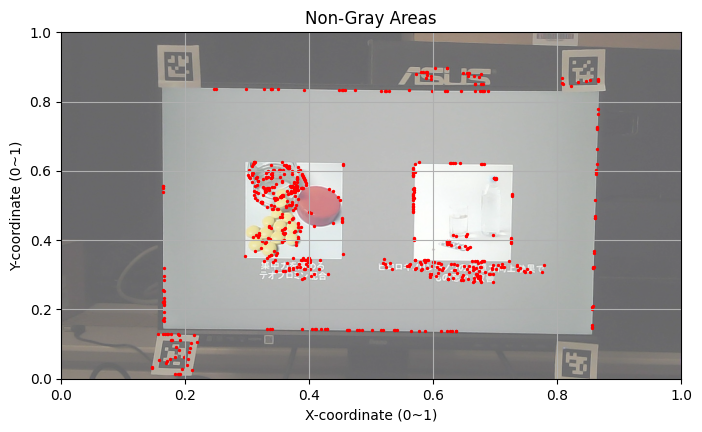

In [7]:
# Load an image
image = cv2.imread('./outputs/frames/20230927_160946/frame_0030.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define a lower and upper threshold for gray color (adjust these values)
lower_gray = 156
upper_gray = 157

# Create a binary mask for non-gray areas based on the threshold
mask = cv2.inRange(gray, lower_gray, upper_gray)

# Find contours of non-gray areas in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store the coordinates of non-gray areas
non_gray_coordinates = []

# Loop through the contours and extract coordinates
for contour in contours:
    for point in contour:
        x, y = point[0]  # Get x and y coordinates
        non_gray_coordinates.append((x, y))

# Convert the list of coordinates to NumPy array for plotting
non_gray_coordinates = np.array(non_gray_coordinates)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4.5))

# Set the background color with 0.6 opacity
ax.set_facecolor((1, 1, 1, 0.6))  # RGBA color with 0.6 opacity

# Scatter plot the non-gray coordinates
ax.scatter(non_gray_coordinates[:, 0] / image.shape[1], 1-(non_gray_coordinates[:, 1] / image.shape[0]), c='red', s=2)  # Normalize coordinates to 0~1
ax.set_title('Non-Gray Areas')
ax.set_xlabel('X-coordinate (0~1)')
ax.set_ylabel('Y-coordinate (0~1)')
ax.invert_yaxis()
ax.grid(True)

# Display the original image as a background with 0.6 opacity
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), extent=(0, 1, 0, 1), aspect='auto', zorder=-1, alpha=0.6)

# Show the plot
plt.show()


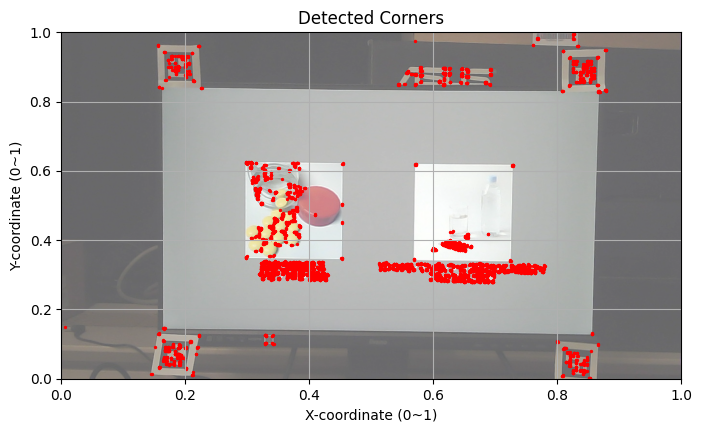

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('./outputs/frames/20230927_160946/frame_0030.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect corners using Harris Corner Detection
corner_image = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Normalize the corner response to scale it for visualization
corner_image = cv2.normalize(corner_image, None, 0, 255, cv2.NORM_MINMAX)

# Define a threshold to filter out weak corners
threshold = 150  # Adjust this threshold as needed

# Create a binary mask for corners above the threshold
corner_mask = corner_image > threshold

# Find coordinates of corners
corner_coordinates = np.argwhere(corner_mask)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4.5))

# Set the background color with 0.6 opacity
ax.set_facecolor((1, 1, 1, 0.6))  # RGBA color with 0.6 opacity

# Scatter plot the corner coordinates
ax.scatter(corner_coordinates[:, 1] / image.shape[1], 1 - corner_coordinates[:, 0] / image.shape[0], c='red', s=2)  # Normalize coordinates to 0~1, invert y-axis
ax.set_title('Detected Corners')
ax.set_xlabel('X-coordinate (0~1)')
ax.set_ylabel('Y-coordinate (0~1)')
ax.invert_yaxis()  # Invert y-axis to match image coordinates (optional)
ax.grid(True)

# Display the original image as a background with 0.6 opacity
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), extent=(0, 1, 0, 1), aspect='auto', zorder=-1, alpha=0.6)

# Show the plot
plt.show()


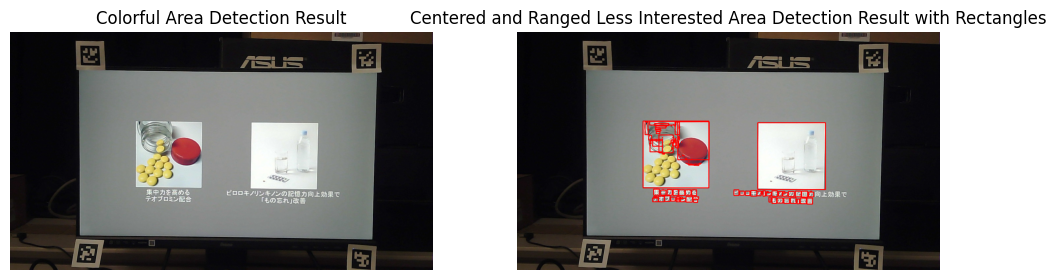

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('./outputs/frames/20230927_160946/frame_0030.jpg')

# Convert the image to the HSV color space (Hue, Saturation, Value)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for detecting colorful areas (excluding gray)
lower_color = np.array([0, 0, 0])  # Adjust these values based on your specific color
upper_color = np.array([180, 180, 180])  # Adjust these values based on your specific color

# Create a mask that separates colorful areas (excluding gray)
color_mask = cv2.inRange(hsv_image, lower_color, upper_color)

# Invert the mask to focus on less interested (black) areas
less_interested_mask = cv2.bitwise_not(color_mask)

# Find contours in the less interested (black) mask
contours, _ = cv2.findContours(less_interested_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store the bounding rectangles around less interested (black) areas in the center
less_interested_rectangles_centered_and_ranged = []

# Calculate the center of the image
image_center_x = image.shape[1] // 2
image_center_y = image.shape[0] // 2

# Define a threshold for considering rectangles as centered
center_threshold = 0.4  # Adjust as needed

# Define the y-coordinate range
y_range_min = 0.2
y_range_max = 0.8

# Loop through the contours to find centered and ranged less interested (black) areas
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the center of the rectangle
    rect_center_x = x + w // 2
    rect_center_y = y + h // 2
    
    # Calculate the distance between the rectangle center and the image center
    distance_to_center = np.sqrt((rect_center_x - image_center_x)**2 + (rect_center_y - image_center_y)**2)
    
    # Check if the rectangle is centered (within the threshold) and within the y-coordinate range
    if (
        distance_to_center <= center_threshold * min(image.shape[0], image.shape[1]) and
        y_range_min <= (y + h) / image.shape[0] <= y_range_max
    ):
        less_interested_rectangles_centered_and_ranged.append((x, y, w, h))

# Draw rectangles around centered and ranged less interested (black) areas on the original image
result_with_centered_and_ranged_rectangles = image.copy()
for x, y, w, h in less_interested_rectangles_centered_and_ranged:
    cv2.rectangle(result_with_centered_and_ranged_rectangles, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red color, line thickness = 2

# Display the result with centered and ranged rectangles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Colorful Area Detection Result')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_with_centered_and_ranged_rectangles, cv2.COLOR_BGR2RGB))
plt.title('Centered and Ranged Less Interested Area Detection Result with Rectangles')
plt.axis('off')

plt.show()


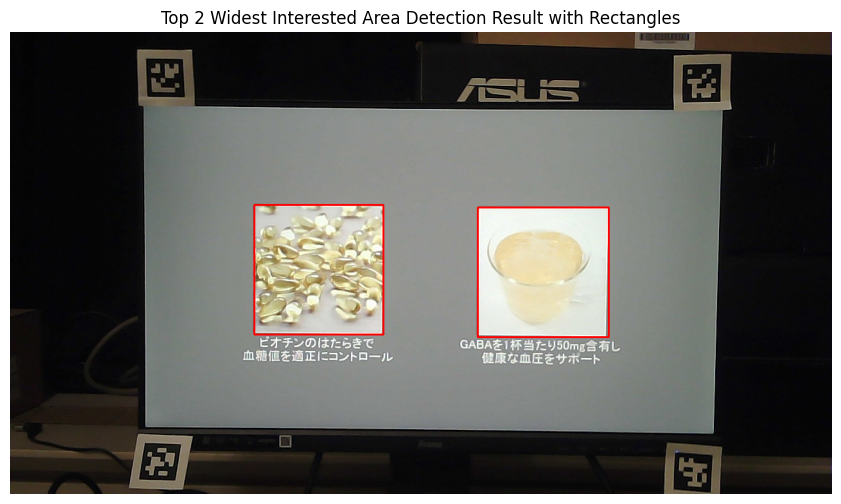

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('./outputs/frames/20230927_160946/frame_0150.jpg')

# Convert the image to the HSV color space (Hue, Saturation, Value)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for detecting colorful areas (excluding gray)
lower_color = np.array([0, 0, 0])  # Adjust these values based on your specific color
upper_color = np.array([180, 180, 180])  # Adjust these values based on your specific color

# Create a mask that separates colorful areas (excluding gray)

color_mask = cv2.inRange(hsv_image, lower_color, upper_color)

# Invert the mask to focus on less interested (black) areas
less_interested_mask = cv2.bitwise_not(color_mask)

# Find contours in the less interested (black) mask
contours, _ = cv2.findContours(less_interested_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store the bounding rectangles around less interested (black) areas in the center
less_interested_rectangles_centered_and_ranged = []

# Calculate the center of the image
image_center_x = image.shape[1] // 2
image_center_y = image.shape[0] // 2

# Define a threshold for considering rectangles as centered
center_threshold = 0.4  # Adjust as needed

# Define the y-coordinate range
y_range_min = 0.2
y_range_max = 0.8

# Loop through the contours to find centered and ranged less interested (black) areas
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the center of the rectangle
    rect_center_x = x + w // 2
    rect_center_y = y + h // 2
    
    # Calculate the distance between the rectangle center and the image center
    distance_to_center = np.sqrt((rect_center_x - image_center_x)**2 + (rect_center_y - image_center_y)**2)
    
    # Check if the rectangle is centered (within the threshold) and within the y-coordinate range
    if (
        distance_to_center <= center_threshold * min(image.shape[0], image.shape[1]) and
        y_range_min <= (y + h) / image.shape[0] <= y_range_max
    ):
        less_interested_rectangles_centered_and_ranged.append((x, y, w, h))

# Sort the rectangles by width in descending order
sorted_rectangles = sorted(less_interested_rectangles_centered_and_ranged, key=lambda rect: rect[2], reverse=True)

# Keep the top 2 widest rectangles
top_2_widest_rectangles = sorted_rectangles[:2]

# Draw rectangles around the top 2 widest centered and ranged less interested (black) areas on the original image
for x, y, w, h in top_2_widest_rectangles:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red color, line thickness = 2

# Display the result with the top 2 widest rectangles
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Top 2 Widest Interested Area Detection Result with Rectangles')
plt.axis('off')

plt.show()
